In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-01-31 17:34:45.365106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 17:34:45.365233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 17:34:45.471857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/40


I0000 00:00:1706722636.868421      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 [==============================] - 34s 306ms/step - loss: 0.9571 - accuracy: 0.6482 - val_loss: 0.6066 - val_accuracy: 0.7880
Epoch 2/40
70/70 [==============================] - 11s 155ms/step - loss: 0.6176 - accuracy: 0.7689 - val_loss: 0.5072 - val_accuracy: 0.8167
Epoch 3/40
70/70 [==============================] - 11s 156ms/step - loss: 0.5122 - accuracy: 0.8167 - val_loss: 0.4591 - val_accuracy: 0.8293
Epoch 4/40
70/70 [==============================] - 11s 158ms/step - loss: 0.4494 - accuracy: 0.8374 - val_loss: 0.4347 - val_accuracy: 0.8446
Epoch 5/40
70/70 [==============================] - 11s 157ms/step - loss: 0.4025 - accuracy: 0.8513 - val_loss: 0.4374 - val_accuracy: 0.8401
Epoch 6/40
70/70 [==============================] - 11s 160ms/step - loss: 0.3525 - accuracy: 0.8724 - val_loss: 0.4259 - val_accuracy: 0.8535
Epoch 7/40
70/70 [==============================] - 11s 163ms/step - loss: 0.3417 - accuracy: 0.8814 - val_loss: 0.4012 - val_accuracy: 0.8518
Epoch 8/40

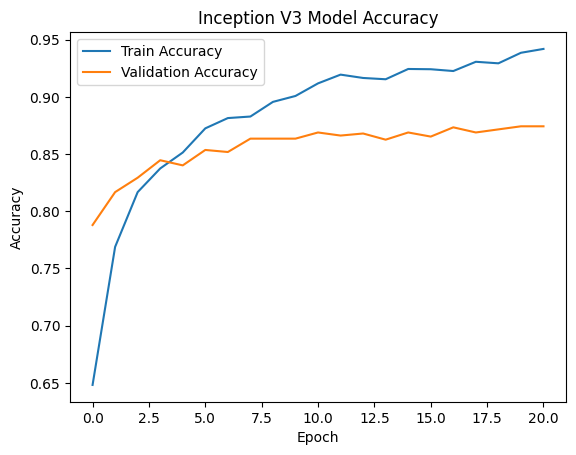

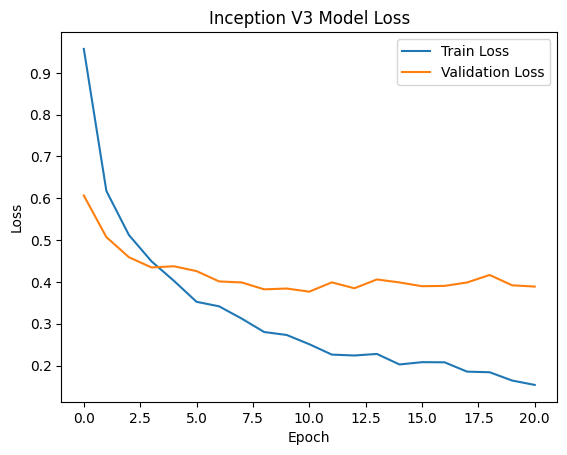

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
from pathlib import Path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

SEED = 999
np.random.seed(SEED)

def load_paths():
    """
    Load file paths and class labels.

    Returns:
        Tuple: A tuple containing a list of file paths and a set of class labels.
    """
    base_path = Path('/kaggle/input/last-alldata/dataset')
    images_pattern = str(base_path / '*' / '*.jpg')
    image_paths = [*glob(images_pattern)]
    image_paths = [p for p in image_paths]
    return image_paths

def load_images_and_labels(image_paths, target_size=(224, 224)):
    """
    Load images and corresponding labels from file paths.

    Args:
        image_paths (list): List of file paths.
        target_size (tuple): Target size for resizing images.

    Returns:
        Tuple: A tuple containing numpy arrays of images and labels.
    """
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)
        label = image_path.split(os.path.sep)[-2]
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

def preprocess_data(X, y):
    """
    Preprocess the data by normalizing images and one-hot encoding labels.

    Args:
        X (numpy array): Array of images.
        y (numpy array): Array of labels.

    Returns:
        Tuple: A tuple containing preprocessed arrays of images and labels.
    """
    X = X.astype('float') / 255.0
    y = LabelBinarizer().fit_transform(y)
    return X, y

def build_model(input_shape=(224, 224, 3), num_classes=6):
    """
    Build an InceptionV3 model for image classification.

    Args:
        input_shape (tuple): Input shape of images.
        num_classes (int): Number of output classes.

    Returns:
        Sequential: Compiled Keras model.
    """
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=40, batch_size=64, early_stopping_patience=10):
    """
    Train the model on the given data.

    Args:
        model (Sequential): Compiled Keras model.
        X_train (numpy array): Training set images.
        y_train (numpy array): Training set labels.
        X_val (numpy array): Validation set images.
        y_val (numpy array): Validation set labels.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        early_stopping_patience (int): Patience for early stopping.

    Returns:
        Tuple: A tuple containing the trained model and training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
    return model, history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set and print the test accuracy.

    Args:
        model (Sequential): Trained Keras model.
        X_test (numpy array): Test set images.
        y_test (numpy array): Test set labels.
    """
    result = model.evaluate(X_test, y_test)
    return result
    
def save_model(model, save_path='/kaggle/working/InceptionV3.h5'):
  
    model.save(save_path)    

def plot_history(history, save_path=None):
    """
    Plot and optionally save the training history.

    Args:
        history (History): Training history from Keras.
        save_path (str): Optional path to save the plots.
    """
    print(history.history.keys())
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Inception V3 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    if save_path:
        plt.savefig(save_path + '_accuracy.png')
    else:
        plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Inception V3 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if save_path:
        plt.savefig(save_path + '_loss.png')
    else:
        plt.show()

def main():
    """
    Main function for loading data, training the model, and evaluating the performance.
    """
    image_paths = load_paths()
    # print(len(image_paths), classes)

    X, y = load_images_and_labels(image_paths)
    X, y = preprocess_data(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    model = build_model()
    trained_model, history = train_model(model, X_train, y_train, X_test, y_test)

    evaluate_model(trained_model, X_test, y_test)
    plot_history(history)

    save_model(trained_model)

if __name__ == "__main__":
    main()
